# Wind Energy Production Prediction

In this notebook, the process of coming to the final model is displayed. It will also explain why we made certain decisions.

## Importing packages 

Importing the needed packages. 

In [68]:
import numpy as np
import optuna
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.utils import shuffle

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print(f"numpy version: {np.__version__}")
print(f"optuna version: {optuna.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"tensorflow version: {tf.__version__}")

numpy version: 2.0.2
optuna version: 4.1.0
pandas version: 2.2.3
matplotlib version: 3.10.0
scikit-learn version: 1.6.1
tensorflow version: 2.18.0


## Loading Data

In this section, we will load the cleaned dataset, which contains both weather data and wind energy production data. This dataset will be used for model training.

In [69]:
df = pd.read_csv('../data/Model/production_wind_data.csv')
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
14582,2022-08-31 14:00:00,Nederland,Wind,Hour,UTC,Providing,Current,3694344,3694344,0.710539,...,2,39,5,0,0,0,0,0,18.354167,19.977016
32124,2021-09-01 13:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,259250,259250,0.118031,...,8,69,5,0,0,0,0,0,16.504167,15.931806
41917,2022-10-14 14:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,336751,336751,0.153316,...,8,87,7,0,0,0,0,0,12.562500,13.050269
48825,2023-07-29 10:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,1490499,1490499,0.678595,...,8,88,7,0,1,0,0,0,18.787500,18.121371
25135,2023-11-14 07:00:00,Nederland,Wind,Hour,UTC,Providing,Current,5865251,5865251,0.960045,...,7,82,7,0,1,0,0,0,11.895833,7.799861


Since the dataset contains some offshore wind data, we will remove those entries to ensure that only mainland wind data is included. 

Offshore wind data could confuse the model since the weather data is from the center of the Netherlands(de Bilt).

In [70]:
# Select only rows where the 'type' column is 'Wind'
df = df[df['type'] == 'Wind']
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
1843,2021-03-18 19:00:00,Nederland,Wind,Hour,UTC,Providing,Current,1166363,1166363,0.318114,...,8,80,5,0,0,0,0,0,4.400000,6.391667
12384,2022-06-01 00:00:00,Nederland,Wind,Hour,UTC,Providing,Current,196948,196948,0.039944,...,8,93,7,0,1,0,0,0,12.608333,17.077361
26156,2023-12-26 20:00:00,Nederland,Wind,Hour,UTC,Providing,Current,376823,376823,0.060943,...,8,97,5,0,0,0,0,0,7.608333,6.888441
9414,2022-01-28 06:00:00,Nederland,Wind,Hour,UTC,Providing,Current,1180572,1180572,0.258469,...,6,82,5,0,0,0,0,0,6.625000,5.299731
24342,2023-10-12 06:00:00,Nederland,Wind,Hour,UTC,Providing,Current,278615,278615,0.046037,...,8,98,7,0,1,0,0,0,15.450000,13.213710


## Predictions

To start the predictions phase, we will select the features that best fit the target. This way, we give the model the best chance to accurately predict the target.

### Feature Selection

In the heatmap displayed in the EDA, we identified the columns that best correlate with the target variable. These columns will be used as features in the model.

In [71]:
# # Convert 'datetime' to datetime format and set as index
# df['datetime'] = pd.to_datetime(df['datetime'])
# df.set_index('datetime', inplace=True)

# Features and target selection
features = ['WindSpeedAvg60min', 'WindGust','WindSpeedAvg10min', 'WindDirection', 'Temperature', 'Pressure']
target = 'capacity'

Next, we will be scaling the data. Scaling the data improves the stability of the training process by ensuring that the features contribute equally during training.

In [72]:
# Scale the data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit and transform features and target
scaled_features = feature_scaler.fit_transform(df[features])
scaled_target = target_scaler.fit_transform(df[[target]])

# Combine scaled features and target
scaled_data = np.hstack([scaled_features, scaled_target])


Next, we will be creating sequences. This step is crucial for time series forecasting as it allows the model to look back upon data from earlier time steps. By creating sequences, we enable the model to capture temporal dependencies and patterns in the data, which can significantly improve the accuracy of our predictions.

In this context, a sequence is a subset of the data that includes a specified number of previous time steps (e.g., the past 24 hours) to predict the next time step. This approach helps the model understand how past observations influence future values.

In [73]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 24  # Use past 24 hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

Next, we split the data into training and testing sets using an 80/20 split, where 80% of the data is used for training and 20% is used for testing. This ensures that the model has enough data to learn from while also having a separate set of data to evaluate its performance.

In [74]:
# # Shuffle the dataset
# X, y = shuffle(X, y, random_state=42)

# Split the dataset with a random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Modeling
To start of the modeling section. We decides to try a couple of different models and improve on the model with the most potential. 

#### LSTM

To start off with LSTM. LSTM stands for Long Short-Term Memory. It is a deep learning model that is comparable to an ARIMA model. While ARIMA is not suited for long-term predictions beyond 6 months, LSTM is more suited for these types of time series predictions.


In [75]:
# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(1)
])
# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


This LSTM model has 5 layers, with the last one being an output layer.

It includes:
- 2 LSTM layers: These layers contain memory cells that allow the model to maintain information over long periods. This makes the LSTM suitable for predictions over data with seasonal trends.
- 2 Dropout layers: These layers randomly drop units during training, forcing the model to learn redundant representations. This improves the model's ability to generalize to new data and prevents overfitting.


In [76]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.35,
    verbose=0
)

# Calculate R2 score for train data
train_predictions = model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)

# Calculate R2 score for test data
predictions = model.predict(X_test)
test_r2 = r2_score(y_test, predictions)

print(f"Train R2 Score: {train_r2}")
print(f"Test R2 Score: {test_r2}")

KeyboardInterrupt: 

The initial model performs quite well and does not appear to be overfitted. Next, we will examine the training performance over all epochs.

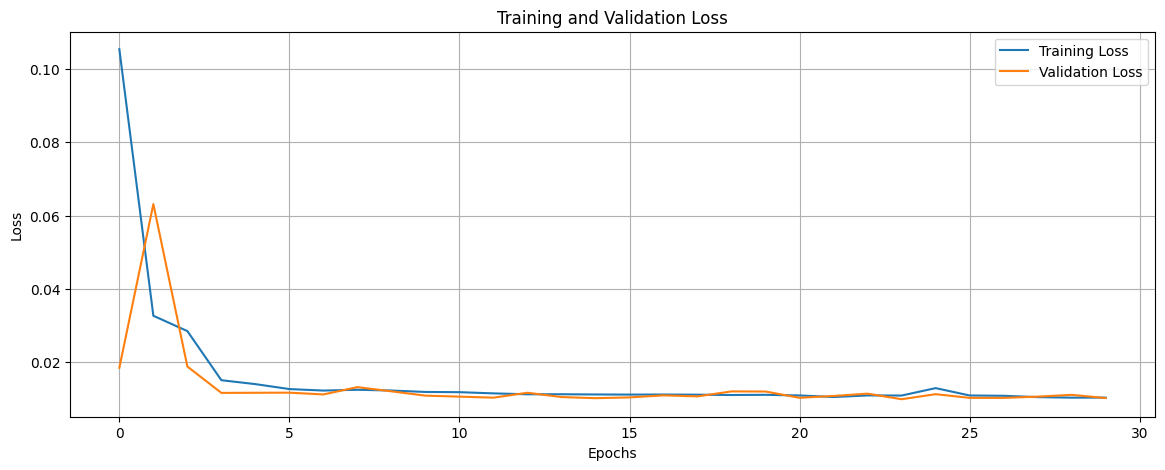

In [ ]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The training and validation loss curves are close to each other, indicating that the model is not overfitting and can generalize well to new data. Overfitting occurs when a model performs well on training data but poorly on validation data, typically seen when the training loss is much lower than the validation loss. In our case, the close alignment of these curves suggests that the model has learned the underlying patterns without memorizing the training data.

The use of dropout layers in the model architecture helps prevent overfitting by randomly dropping units during training, forcing the model to learn redundant representations. This improves the model's ability to generalize to new data.

Overall, the training and validation loss curves indicate that the model performs well and can generalize effectively to unseen data.

Next, we will print a plot that will show the predicte values against the actual values. 

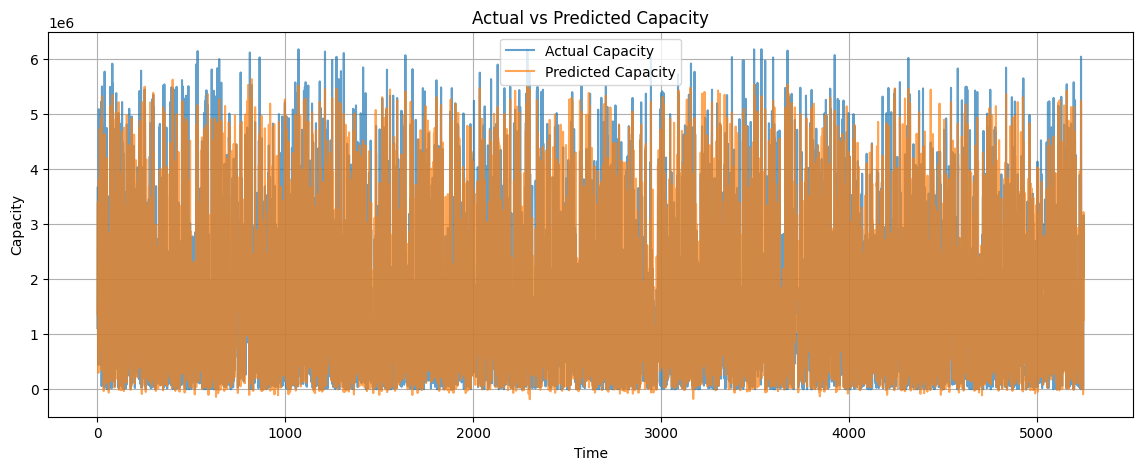

In [63]:
# Inverse transform predictions and actual values
predicted_capacity = target_scaler.inverse_transform(predictions)
actual_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot Predictions vs Actual Values
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_capacity, label='Predicted Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

From this, you can see that it does predict the trends very well. It predicts lower than the actual values, but it does show the same waves as the actual values.

#### RNN

RNNs (Recurrent Neural Networks) are designed to recognize patterns in sequences of data, making them ideal for tasks like time series forecasting. Unlike traditional neural networks, RNNs maintain a memory of previous inputs through directed cycles in their connections.

While LSTMs (Long Short-Term Memory) are a type of RNN for handling long-term dependencies, standard RNNs can still be effective for certain time series data. RNNs process input data step-by-step, updating a hidden state that captures information from previous steps.

We'll use a simple RNN model to predict wind energy production from past weather data and compare its performance with an LSTM model to see which is better for our task.

In [ ]:
# Build the RNN model
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    SimpleRNN(256),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn_model.summary()


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 24, 128)        │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,097 (453.50 KB)

 Trainable params: 116,097 (453.50 KB)

 Non-trainable params: 0 (0.00 B)

The structure of the RNN model is similar to that of the LSTM model. The RNN model has 5 layers:

* 2 SimpleRNN layers: Recognize patterns in sequences.
* 2 Dropout layers: Prevent overfitting by randomly dropping units during training.
* 1 Dense output layer: Produces the final prediction.

RNNs process input data step-by-step, maintaining a hidden state with information from previous steps. We'll use this RNN model to predict wind energy production from past weather data and compare it with an LSTM model.

In [ ]:
# Train the RNN model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
# Make predictions using the RNN model
rnn_predictions = rnn_model.predict(X_test)
rnn_test_r2 = r2_score(y_test, rnn_predictions)

rnn_train_predictions = rnn_model.predict(X_train)

rnn_train_r2 = r2_score(y_train, rnn_train_predictions)

print(f"RNN Train R2 Score: {rnn_train_r2}")
print(f"RNN Test R2 Score: {rnn_test_r2}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RNN Train R2 Score: 0.815893927216042
RNN Test R2 Score: 0.8158888778083087


The initial training performs well. The R² score is slightly higher than the LSTM, and the difference between test and train scores indicates that it is not overfitted. 

Next, we will be looking at the training loss versus validation loss. 

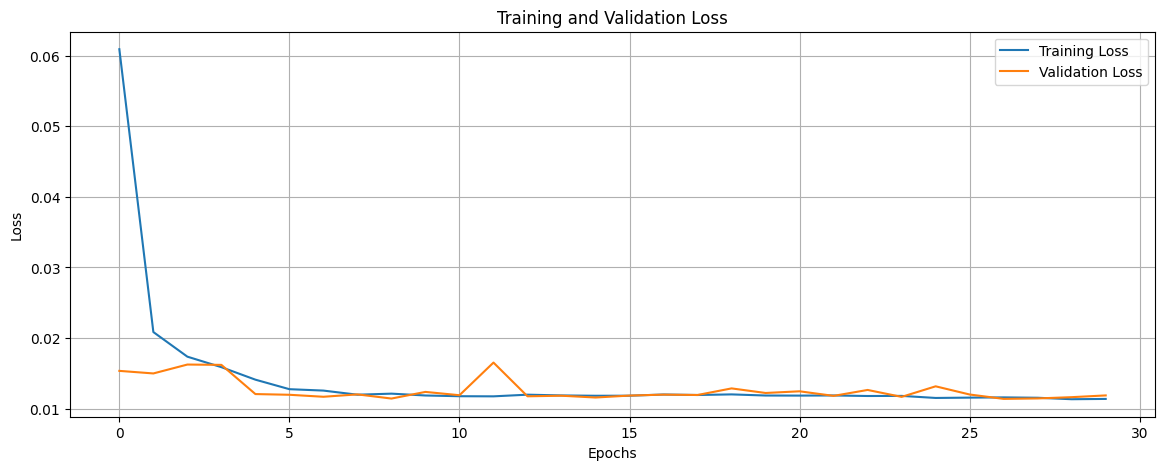

In [ ]:
# Inverse transform the predictions
predicted_rnn_capacity = target_scaler.inverse_transform(rnn_predictions)
actual_rnn_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The lines of the training and validation loss are very close to each other, meaning it is not overfitted.

Next, we will look at the predicted versus actual values.

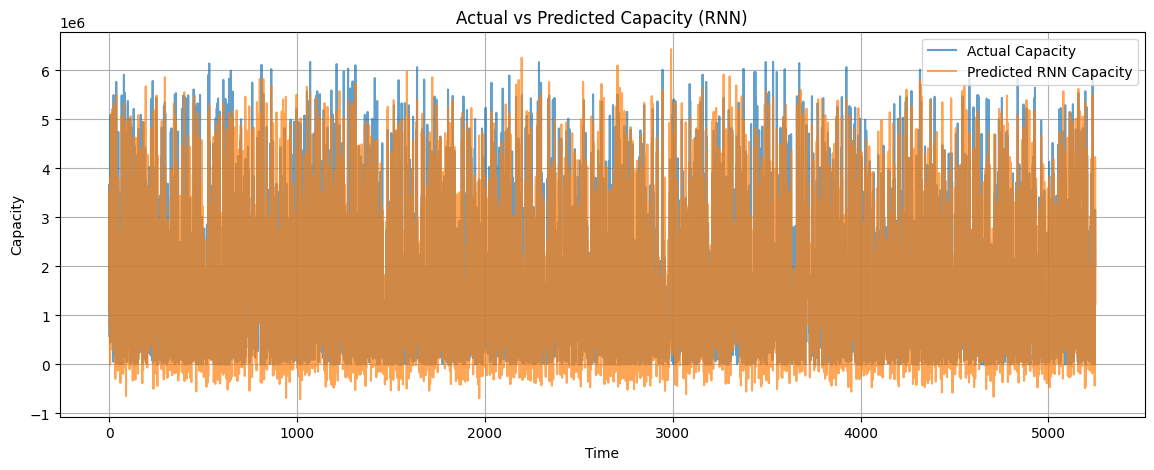

In [ ]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

The actual versus predicted values seem to be predicting better. It still shows that the predicted values are lower than the actual values, but they are closer to each other.

##### Comparisons

Because it is really hard to see which model preforms the best we will be comparinf the two next to eachouther. 